Importing the necessary libraries

In [24]:
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import os

Finding the files inside the folder and reading the images

In [42]:
def find_files(basename: str):
    files = []

    for filename in os.listdir(os.getcwd()):
        if os.path.basename(filename).startswith(basename):
            files.append(os.path.join(os.getcwd(), filename))
    return files

def read_image(image_path: str):
    image = imageio.imread(image_path, mode='L')
    return image

A simple function to show image

In [26]:
def show_image(image: np.ndarray):
  plt.imshow(image , cmap='gray')

Arrays of files found by the basename, process them into images.np format and append them to array of images (images in np:ndarray format)

In [27]:
files_found = []
images = []
image_basename = str(input().strip())
files_found = find_files(image_basename)
for file in files_found:
    images.append(read_image(file))

01_low


Function responsible for returning a histogram with a certain ammount of levels (no_levels) for a given image

In [28]:
def histogram(image: np.ndarray, no_levels):
  lines, columns = image.shape
  hist = np.zeros(no_levels).astype(int)

  for i in range(no_levels):
    nopix_value_i = np.sum(image == i)

    hist[i] = nopix_value_i

  return(hist)

Text(0, 0.5, 'Frequency')

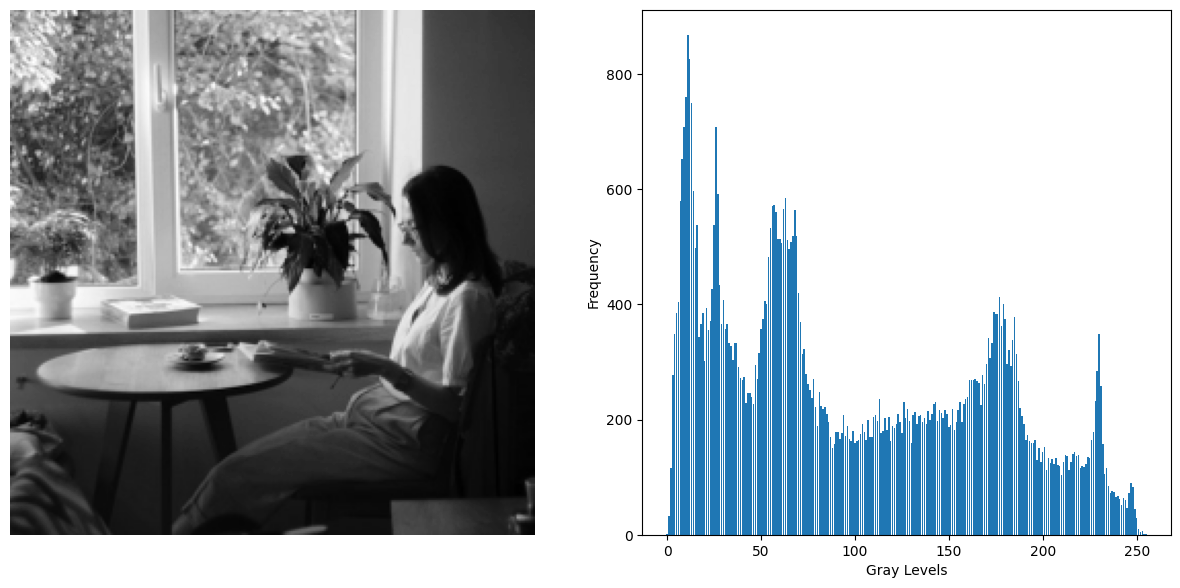

In [29]:
  hist_A = histogram(images[0], 256)
  plt.figure(figsize=(15,15))
  plt.subplot(2,2,1)
  # show_image(images[0])
  plt.imshow(images[0], cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.subplot(2,2,2)
  plt.bar(range(256), hist_A)
  plt.xlabel('Gray Levels')
  plt.ylabel('Frequency')


Histogram equalization

In [43]:
def histogram_equalization(image:np.ndarray , no_levels):
  hist = histogram(image, no_levels) #compute the histogram of the image
  histRes = np.zeros(no_levels).astype(int) #initialize the histogram of the new image

  histRes[0] = hist[0]
  for i in range(1, no_levels):
    histRes[i] = hist[i] + histRes[i-1]

  #store the lookup table
  hist_transf = np.zeros(no_levels).astype(np.uint8)

  #image resolution
  lines, columns = image.shape

  image_eq = np.zeros([lines, columns]).astype(np.uint8)

  #loop through every intensity value possible and transform all those (z) in the image
  for z in range(no_levels):
    s = int((no_levels - 1)*histRes[z]/(float(lines*columns)))
    #making the histogram for the new image
    hist_transf[z] = s

    #for every coordinate in which A == z, replace it with s
    image_eq[np.where(image==z)] = s

  return (image_eq, hist_transf)


Text(0, 0.5, 'output pixel value')

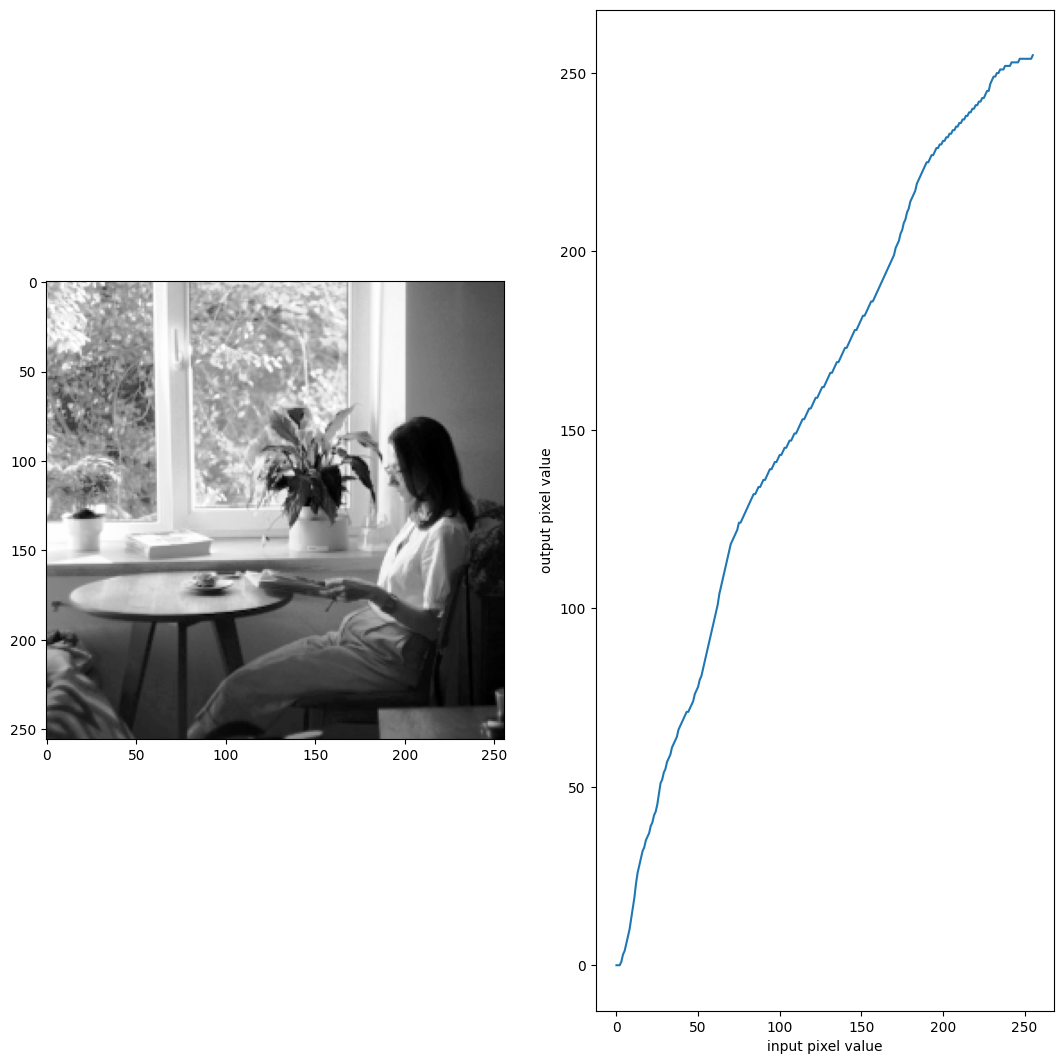

In [31]:
imgA, imgA_transf = histogram_equalization(images[0], 256)
plt.figure(figsize=(13,13))
plt.subplot(1,2,1)
plt.imshow(imgA, cmap='gray', vmin=0, vmax=255)
# plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(256), imgA_transf)
plt.xlabel('input pixel value')
plt.ylabel('output pixel value')


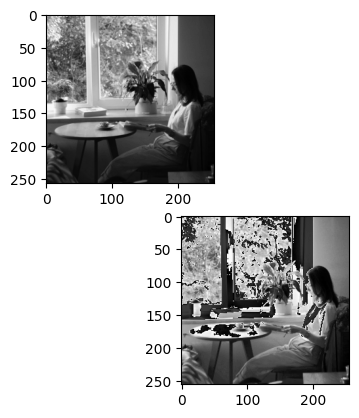

In [45]:
def histogram_equalization_multi(images: list, no_levels):

    cumulative_hist = np.zeros(no_levels)
    equalized_images = [] #to store the equalized images

    #compute the cumulative hist over the histograms of all images
    for image in images:
        hist = histogram(image, no_levels)
        cumulative_hist += hist

    #perform histogram equalization using the cumulative histogram
    histRes = np.zeros(no_levels).astype(int)
    histRes[0] = cumulative_hist[0]
    for i in range(1, no_levels):
        histRes[i] = cumulative_hist[i] + histRes[i-1]

    #store the lookup table
    hist_transf = np.zeros(no_levels)

    #loop through every intensity value possible and transform all those (z) in the image
    for z in range(no_levels):
        s = int((no_levels - 1) * histRes[z] / (float(image.shape[0] * image.shape[1])*4))
        hist_transf[z] = s

    #apply histogram equalization to each image

    for image in images:
        lines, columns = image.shape
        image_eq = np.zeros([lines, columns]).astype(np.uint8) #initialize the equalized image

        #for every coordinate in which A == z, replace it with s
        for z in range(no_levels):
            image_eq[np.where(image == z)] = hist_transf[z]
        equalized_images.append(image_eq)

    return equalized_images, hist_transf

# Example usage
# Assuming images_list is a list containing N images
plt.subplot(2,2,1)
plt.imshow(images[0], cmap='gray', vmin=0, vmax=255)
equalized_images, hist_transf = histogram_equalization_multi(images, 256)
plt.subplot(2,1,2)
plt.imshow(equalized_images[0], cmap='gray', vmin=0, vmax=255)


In [46]:
def gama_correction(image:np.ndarray, value:float):
  lines, columns = image.shape
  image_corr = np.zeros([lines, columns]).astype(np.uint8)

  #loop through every intensity value possible and transform all those (z) in the image
  for z in range(256):
    s = (255)*(z/(255))**float(1/value)

    #for every coordinate in which A == z, replace it with s
    image_corr[np.where(image==z)] = s

  #compute the histogram relative to the corrected image
  hist = histogram(image_corr, 256)
  return (image_corr, hist)


Text(0, 0.5, 'output pixel value')

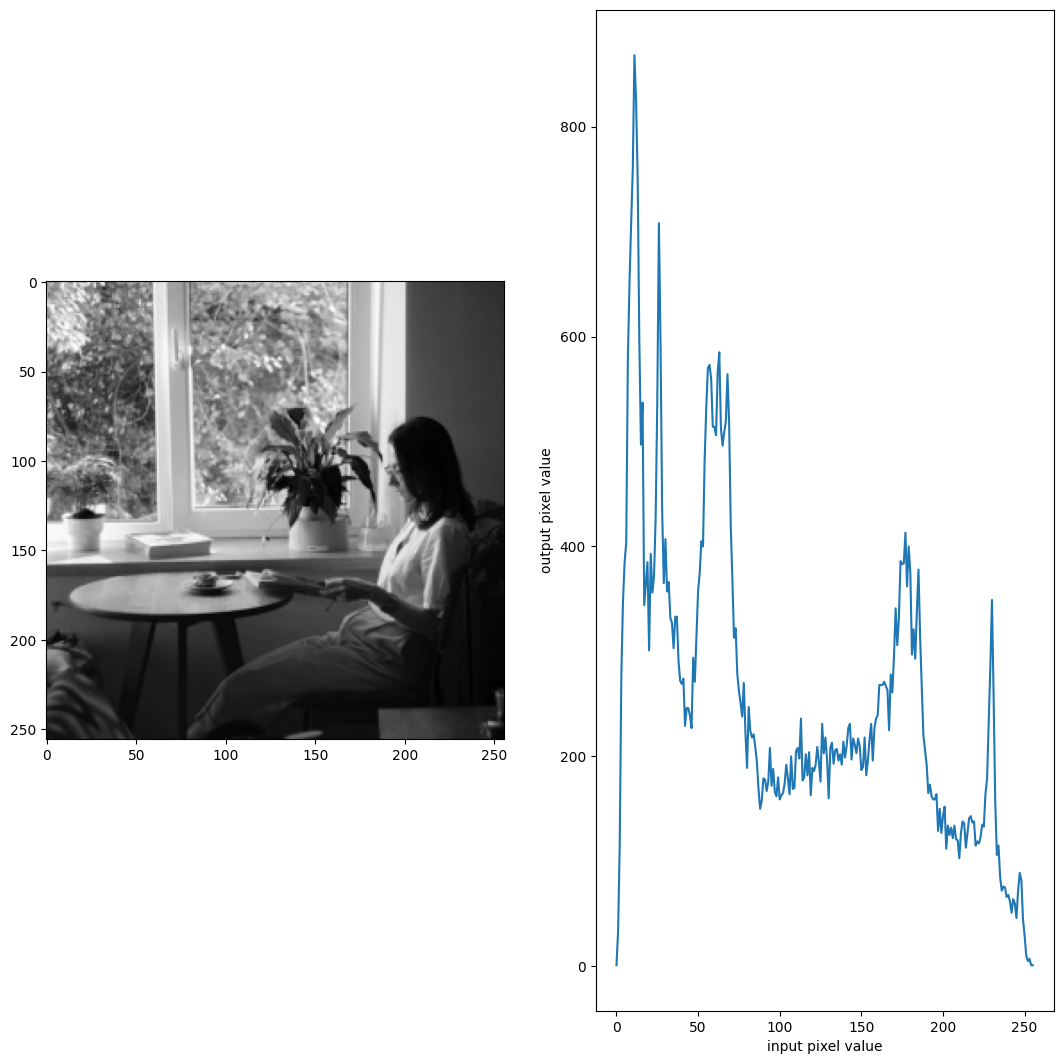

In [47]:
imgB, histB = gama_correction(images[0], 1.0)
plt.figure(figsize=(13,13))
plt.subplot(1,2,1)
plt.imshow(imgB, cmap='gray', vmin=0, vmax=255)
# plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(256), histB)
plt.xlabel('input pixel value')
plt.ylabel('output pixel value')

Hiperresolution function, responsible for turning an image of resolution A x B to 2A x 2B

In [49]:
def hiperress(images:np.ndarray):

  new_img = np.empty((2*images[0].shape[0], 2*images[0].shape[1]))

  for i in range(images[0].shape[0]):
    for j in range(images[0].shape[1]):
      new_img[2*i][2*j] = images[0][i][j]
      new_img[(2*i)+1][2*j] = images[1][i][j]
      new_img[2*i][(2*j)+1] = images[2][i][j]
      new_img[(2*i)+1][(2*j)+1] = images[3][i][j]
  # print(new_img)
  return new_img


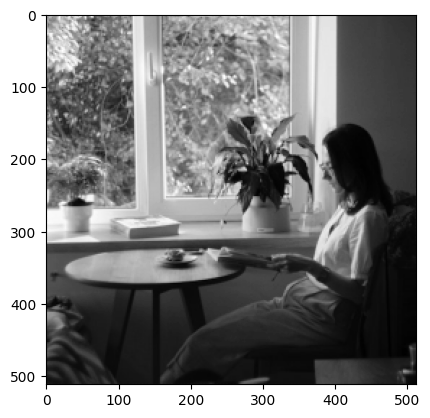

In [50]:
res_image = hiperress(images)
plt.imshow(res_image, cmap='gray', vmin=0, vmax=255)

In [51]:
def rmse(old_image, highres_image):
  lines, columns = old_image.shape
  cum_sum = 0
  for i in range(lines):
    for j in range(columns):
      cum_sum += pow((old_image[i][j] - highres_image[i][j]), 2)

  cum_sum /= lines*columns
  return np.sqrt(cum_sum)

In [59]:

def main():
  files_found = []
  images = []
  post_proc = []

  image_basename = str(input().strip()) #input the base name of the images
  files_found = find_files(image_basename)
  for file in files_found:
      images.append(read_image(file)) #open the images and store them

  high_res_file = find_files(str(input().strip())) #input the high resolution image
  high_res_image = read_image(high_res_file[0])

  option = int(input().strip())
  parameter = float(input().strip())

  match option:
    case 0:
      print(rmse(high_res_image, hiperress(images)))
    case 1:
      for i in range(4):
        post_proc.append(histogram_equalization(images[i], 256)[0])
      print("%.4f" % rmse(high_res_image, hiperress(post_proc)))
    case 2:
      post_proc = histogram_equalization_multi(images, 256)[0]
      print("%.4f" % rmse(high_res_image,hiperress(post_proc)))
    case 3:
      for i in range(4):
        post_proc.append(gama_correction(images[i], parameter)[0])
      print("%.4f" % rmse(high_res_image, hiperress(post_proc)))

if __name__ == '__main__':
   main()

01_low
01_high.png
1
1.0
9.3049
